# Learning a Linear Elastic System with a Bayesian Deep Operator Network

This example uses a Bayesian Deep Operator Network to learn the response of a linear elastic system.

## Import Necessary Tools
First, we import our tensor and plotting libraries. Then we import the Bayesian layers `BayesianLayer` and `BayesainConvLayer`, the Deep Operator Network `DeepOperatorNetwork`, and the Bayes by backpropagation algorithm `BBBTrainer` from UQpy.

For convenience, UQpy's logging statements are printed to console.

In [6]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from scipy.io import savemat
from matplotlib import pyplot as plt

from UQpy.scientific_machine_learning.layers import BayesianLayer, BayesianConvLayer
from UQpy.scientific_machine_learning.neural_networks import DeepOperatorNetwork
from UQpy.scientific_machine_learning.trainers import BBBTrainer
from ..dataset import load_data, rescale

import logging

logger = logging.getLogger("UQpy")
logger.setLevel(logging.INFO)

ImportError: attempted relative import with no known parent package

## Define the Neural Operator

Here we define the branch and trunk networks, similar to how they were defined in the deterministic case. The important difference in the Bayesian method is the use of the Bayesian layers implemented by `BayesianLayer` and `BayesianConvLayer`, which are Bayesian versions of full connected linear layers and 2D convolution layers, respectively.

The dictionary ``priors`` define the parameters for the Normal distributions that govern the weights and bias in each layer. 

In [3]:
priors = {
    "prior_mu": 0,
    "prior_sigma": 0.01,
    "posterior_mu_initial": (0, 0.1),
    "posterior_rho_initial": (-5, 0.1),
}

In [4]:
class BranchNet(nn.Module):
    """Branch network for the deep operator network"""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fnn = nn.Sequential(BayesianLayer(101, 100, priors=priors), nn.Tanh())
        self.conv_layers = nn.Sequential(
            BayesianConvLayer(1, 16, (5, 5), padding="same", priors=priors),
            nn.AvgPool2d(2, 1, padding=0),
            BayesianConvLayer(16, 16, (5, 5), padding="same", priors=priors),
            nn.AvgPool2d(2, 1, padding=0),
            BayesianConvLayer(16, 16, (5, 5), padding="same", priors=priors),
            nn.AvgPool2d(2, 1, padding=0),
            BayesianConvLayer(16, 64, (5, 5), padding="same", priors=priors),
            nn.AvgPool2d(2, 1, padding=0),
        )
        self.dnn = nn.Sequential(
            nn.Flatten(),
            BayesianLayer(64 * 6 * 6, 512, priors=priors),
            nn.Tanh(),
            BayesianLayer(512, 512, priors=priors),
            nn.Tanh(),
            BayesianLayer(512, 200, priors=priors),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fnn(x)  # Single fully connected Bayesian layer
        x = x.view(-1, 1, 10, 10)
        x = self.conv_layers(x)  # Bayesian convolution layers
        x = self.dnn(x)  # 3 fully connected Bayesian layers
        return x


class TrunkNet(nn.Module):
    """Trunk network for the deep operator network"""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fnn = nn.Sequential(
            BayesianLayer(2, 128, priors=priors),
            nn.Tanh(),
            BayesianLayer(128, 128, priors=priors),
            nn.Tanh(),
            BayesianLayer(128, 128, priors=priors),
            nn.Tanh(),
            BayesianLayer(128, 200, priors=priors),
            nn.Tanh(),
        )
        self.Xmin = np.array([0.0, 0.0]).reshape((-1, 2))
        self.Xmax = np.array([1.0, 1.0]).reshape((-1, 2))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = 2.0 * (x - self.Xmin) / (self.Xmax - self.Xmin) - 1.0
        x = x.float()
        x = self.fnn(x)
        return x


branch_network = BranchNet()
trunk_network = TrunkNet()
model = DeepOperatorNetwork(branch_network, trunk_network, 2)

# Define the Data

With our model defined, we turn our attention to the training and testing data. UQpy's deep operator network uses Pytorch's `Dataset` and `DataLoader` to define the inputs and labeled outputs.

Additionally, we define our loss function as the mean square error between the network's prediction and the true value. As is standard in Pytorch, the `LossFunction` is also defined as a subclass of ``nn.Module``.

The data and loss function are identical to the deterministic case.

In [5]:
class LossFunction(nn.Module):
    """Define the data loss function during training
    Note: KL Divergence is computed separately by the BBBTrainer
    """

    def __init__(self, reduction: str = "mean", *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.reduction = reduction

    def forward(self, prediction, label):
        return F.mse_loss(
            prediction[0], label[0], reduction=self.reduction
        ) + F.mse_loss(
            prediction[1], label[1], reduction=self.reduction
        )


class ElasticityDataSet(Dataset):
    """Format the elasticity dataset"""

    def __init__(self, x, f_x, u_x, u_y):
        self.x = x
        self.f_x = f_x
        self.u_x = u_x
        self.u_y = u_y

    def __len__(self):
        return int(self.f_x.shape[0])

    def __getitem__(self, i):
        return self.x, self.f_x[i, :], (self.u_x[i, :, 0], self.u_y[i, :, 0])


(F_train, Ux_train, Uy_train, F_test, Ux_test, Uy_test,
 X, ux_train_mean, ux_train_std, uy_train_mean, uy_train_std,) = load_data()
train_data = DataLoader(
    ElasticityDataSet(
        np.float32(X), np.float32(F_train), np.float32(Ux_train), np.float32(Uy_train)
    ),
    batch_size=100,
    shuffle=True,
)
test_data = DataLoader(
    ElasticityDataSet(
        np.float32(X), np.float32(F_test), np.float32(Ux_test), np.float32(Uy_test)
    ),
    batch_size=100,
    shuffle=True,
)

## Train the Model
With the model, data, and loss function defined all that remains is to specify our optimization algorithm and train the model. We use Pytorch's implementation of the Adam algorithm.

The `trainer` object assembles the model, optimization algorithm, loss function, and data to learn the weights of the model that minimize the loss function evaluated on all training data.

For convience, the model as already been trained and its weights saved. The code below was used to train the model and save the results.

```python
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
trainer = BBBTrainer(model, optimizer, LossFunction())
trainer.run(
    train_data=train_data,
    test_data=test_data,
    epochs=300,
    tolerance=1e-4,
    beta=1e-8,
    num_samples=1,
)
torch.save(model.state_dict(), "bayesian_linear_elastic_parameters.pt")

train_loss = trainer.history["train_nll"].detach().numpy()
test_loss = trainer.history["test_nll"].detach().numpy()
np.save("bayesian_linear_elastic_train_loss.npy", train_loss)
np.save("bayesian_linear_elastic_test_loss.npy", test_loss)
```

In [6]:
model = DeepOperatorNetwork(branch_network, trunk_network, 2)
model.load_state_dict(torch.load("bayesian_linear_elastic_parameters.pt"))
model.eval()

DeepOperatorNetwork(
  (branch_network): BranchNet(
    (fnn): Sequential(
      (0): BayesianLayer(in_features=101, out_features=100, sampling=True)
      (1): Tanh()
    )
    (conv_layers): Sequential(
      (0): BayesianConvLayer(in_channels=1, out_channels=16, stride=1, padding=same, sampling=True)
      (1): AvgPool2d(kernel_size=2, stride=1, padding=0)
      (2): BayesianConvLayer(in_channels=16, out_channels=16, stride=1, padding=same, sampling=True)
      (3): AvgPool2d(kernel_size=2, stride=1, padding=0)
      (4): BayesianConvLayer(in_channels=16, out_channels=16, stride=1, padding=same, sampling=True)
      (5): AvgPool2d(kernel_size=2, stride=1, padding=0)
      (6): BayesianConvLayer(in_channels=16, out_channels=64, stride=1, padding=same, sampling=True)
      (7): AvgPool2d(kernel_size=2, stride=1, padding=0)
    )
    (dnn): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): BayesianLayer(in_features=2304, out_features=512, sampling=True)
      (2): Tanh

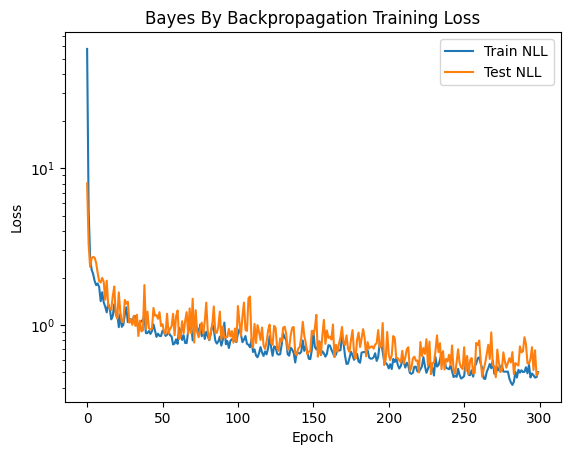

In [7]:
train_loss = np.load("bayesian_linear_elastic_train_loss.npy")
test_loss = np.load("bayesian_linear_elastic_test_loss.npy")

fig, ax = plt.subplots()
ax.plot(train_loss, label='Train NLL')
ax.plot(test_loss, label='Test NLL')
ax.set_title("Bayes By Backpropagation Training Loss")
ax.set(xlabel="Epoch", ylabel="Loss")
ax.legend()
ax.set_yscale('log')

## Visualize the Bayesian Deep Operator Network Prediction

We compare the prediction from our model to the truth on a sample from the test data set. The Python below formats the prediction for a MatLab script that produced the plot below.

In the first column on the left, we have the applied loading. The second column shows true displacements in both $X$ and $Y$ and the third column shows our model's mean predictions. The fourth column shows the variance of the model predictions. Note that the variance is *not* uniform across the entire domain. In the fifth column, right, shows the error between the mean prediction and true value.

![A comparison of the Bayesian deep operator network prediction and the truth on a sample from the test case](Predictions_Bayesian/TestCase8.png)

In [1]:
def eval_model(test_data, model, uq=False):
    """Evaluate test data and save results"""
    if uq:
        model.train()
    else:
        model.eval()
    ux_pred_list = []
    uy_pred_list = []
    ux_test_list = []
    uy_test_list = []
    x_list = []
    for batch_number, (*x, y) in enumerate(test_data):
        ux_pred, uy_pred = model(*x)
        ux_test, uy_test = y
        ux_pred_list.append(ux_pred)
        uy_pred_list.append(uy_pred)
        ux_test_list.append(ux_test)
        uy_test_list.append(uy_test)
        x_list.append(x[1][:, 0, :])
    return torch.cat(ux_pred_list), torch.cat(uy_pred_list), torch.cat(ux_test_list), torch.cat(
        uy_test_list), torch.cat(x_list)

# Rescale data by adding mean and scaling by standard deviation
ux_pred, uy_pred, ux_test, uy_test, x_test = eval_model(test_data, model)
ux_pred = rescale(ux_pred.detach(), np.squeeze(ux_train_mean, axis=2), np.squeeze(ux_train_std, axis=2))
uy_pred = rescale(uy_pred.detach(), np.squeeze(uy_train_mean, axis=2), np.squeeze(uy_train_std, axis=2))
ux_test = rescale(ux_test.detach(), np.squeeze(ux_train_mean, axis=2), np.squeeze(ux_train_std, axis=2))
uy_test = rescale(uy_test.detach(), np.squeeze(uy_train_mean, axis=2), np.squeeze(uy_train_std, axis=2))
# Compute forward model predictions
num_uq_samps = 100
ux_pred_list = []
uy_pred_list = []
for i in range(num_uq_samps):
    ux_samp_pred, uy_samp_pred, _, _, _ = eval_model(test_data, model, uq=True)
    ux_samp_pred = rescale(ux_samp_pred.detach(), np.squeeze(ux_train_mean, axis=2), np.squeeze(ux_train_std, axis=2))
    uy_samp_pred = rescale(uy_samp_pred.detach(), np.squeeze(uy_train_mean, axis=2), np.squeeze(uy_train_std, axis=2))
    ux_pred_list.append(ux_samp_pred)
    uy_pred_list.append(uy_samp_pred)
ux_sigma = np.std(ux_pred_list, axis=0)
uy_sigma = np.std(uy_pred_list, axis=0)
# Save predictions for MatLab plotting script
savemat('Bayesian_Elastic_plate.mat',
        {'x_test': x_test.detach().numpy(),
         'ux_test': ux_test.detach().numpy(),
         'uy_test': uy_test.detach().numpy(),
         'ux_pred': ux_pred.detach().numpy(), 
         'uy_pred': uy_pred.detach().numpy(), 
         'ux_sigma': ux_sigma,
         'uy_sigma': uy_sigma}
        )

NameError: name 'model' is not defined

## Plot the Distribution of Weights in the DeepONet

Each weight in the deep operator network is represented by a normal random variable. We can visualize these distributions by plotting the pdf of the random variable with the mean and standard deviation learned from the training. Here we plot the pdf of several weights in the fully connected portion of the branch network, `model.branch_network.fnn`. 

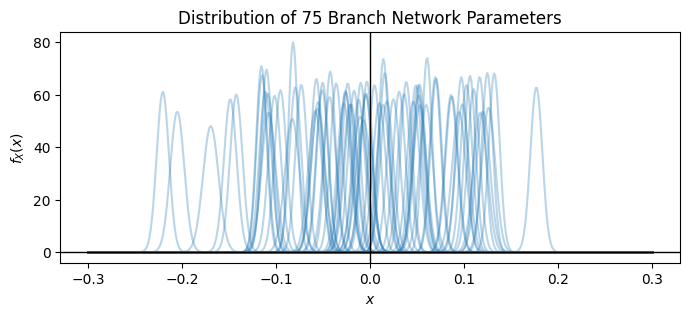

In [46]:
from UQpy.distributions import Normal
mean = model.branch_network.fnn[0].weight_mu.flatten()
rho = model.branch_network.fnn[0].weight_sigma.flatten()
standard_deviation = torch.log(1 + torch.exp(rho))

n = 75
x = np.linspace(-0.3, 0.3, num=500)
fig, ax = plt.subplots(figsize=(8, 3))
for i in range(n):
    distribution = Normal(float(mean[i]), float(standard_deviation[i]))
    ax.plot(x, distribution.pdf(x), color="tab:blue", alpha=0.3)
ax.set_title(f"Distribution of {n} Branch Network Parameters")
ax.set(xlabel="$x$", ylabel="$f_X(x)$")
ax.axvline(0, color="black", lw=1)
ax.axhline(0, color="black", lw=1)
plt.show()